# BM20A6100 Advanced Data Analysis and Machine Learning
# Exercise: Nonlinear Dimensionality Reduction

# *1. Comparing linear and non-linear DR (4 points)*

Compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset. Explore how the different features are shown in the DR components. Build a simple prediction model (for example, MLP or Random Forest) to predict the count of total rental bikes and compare the performance of the model with the different DR techniques.

## Libraries import

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from scipy.io import arff

## Load data

Loaded dataset from arff file. The target variable is 'count', the input variables are the all remaining except 'casual' and 'registered', because they are together forming the target variable (they are not independent variables and thus were removed). 

The one-hot encoding is next applied to the input categorical variables. As the next step, the input variables are scaled by a Standard Scaler (z-score standardisation). 

In [2]:
bs_data, bs_meta = arff.loadarff('bs_dataset.arff')
bs_df = pd.DataFrame(bs_data)

for col in bs_df.select_dtypes(['object']):
    bs_df[col] = bs_df[col].str.decode('utf-8')

print(bs_df.head())

bs_X = bs_df.drop(columns=['count', 'casual', 'registered'])
bs_y = bs_df['count']

bs_X_enc = pd.get_dummies(bs_X, drop_first=True)
bs_X_scaled = StandardScaler().fit_transform(bs_X_enc)

   season  year  month  hour holiday  weekday workingday weather  temp  \
0  spring   0.0    1.0   0.0   False      6.0      False   clear  9.84   
1  spring   0.0    1.0   1.0   False      6.0      False   clear  9.02   
2  spring   0.0    1.0   2.0   False      6.0      False   clear  9.02   
3  spring   0.0    1.0   3.0   False      6.0      False   clear  9.84   
4  spring   0.0    1.0   4.0   False      6.0      False   clear  9.84   

   feel_temp  humidity  windspeed  casual  registered  count  
0     14.395      0.81        0.0     3.0        13.0   16.0  
1     13.635      0.80        0.0     8.0        32.0   40.0  
2     13.635      0.80        0.0     5.0        27.0   32.0  
3     14.395      0.75        0.0     3.0        10.0   13.0  
4     14.395      0.75        0.0     0.0         1.0    1.0  


## PCA

In the PCA biplot, the variables temp and feel_temp have strong loadings on the first principal component, indicating that temperature-related features explain a large portion of the data variance. The dummy variables for seasons (season_spring, season_summer, season_winter) also show directional influence, meaning that seasonal variation contributes to differences among observations. Humidity and windspeed go in opposite directions (loadings almost opposite each other), so when humidity is high, wind tends to be lower (and vice versa).

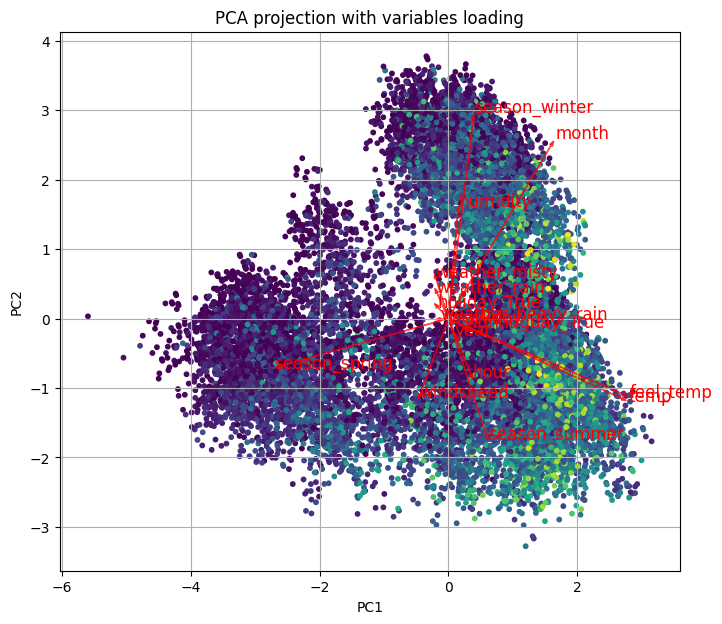

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(bs_X_scaled)

# Vizualisation in PCA space
plt.figure(figsize=(8,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=bs_y, cmap='viridis', s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection with variables loading')

# Loading vectors
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=bs_X_enc.columns
)
for i, feature in enumerate(loadings.index):
    plt.arrow(
        0, 0,
        loadings.PC1.iloc[i] * 5,
        loadings.PC2.iloc[i] * 5,
        color='r', alpha=0.7, head_width=0.05
    )
    plt.text(
        loadings.PC1.iloc[i] * 5.2,
        loadings.PC2.iloc[i] * 5.2,
        feature, color='red', fontsize=12
    )

plt.grid(True)
plt.show()


## t-SNE

The t-SNE visualization of the target variable 'count' shows that bike rental demand is organized into distinct nonlinear clusters rather than following a smooth continuous trend. Most data points correspond to periods of low rental activity, whereas a few dense clusters indicate conditions of exceptionally high demand. These high-demand regions likely reflect specific combinations of warm temperatures, favorable weather, and particular hours of the day. Overall, the embedding demonstrates that rental behavior is strongly context-dependent and driven by complex interactions between temporal and environmental factors, rather than by single linear influences. 

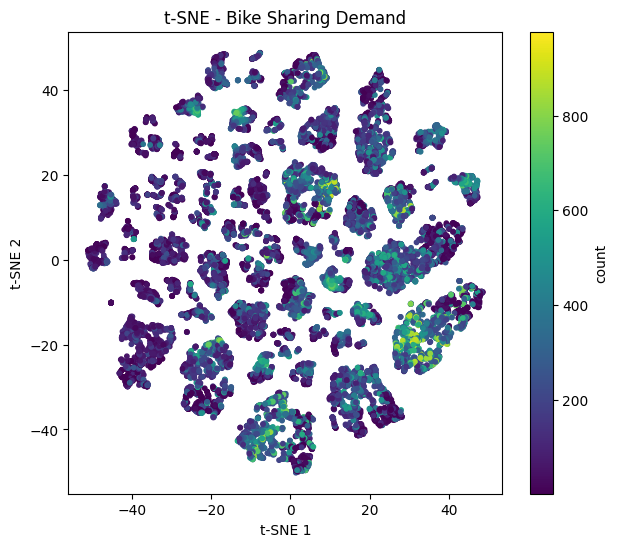

In [4]:
tsne = TSNE(n_components=2, perplexity=40, max_iter=500, random_state=42)
X_tsne = tsne.fit_transform(bs_X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=bs_y, cmap='viridis', s=10)
plt.colorbar(label='count')
plt.title('t-SNE - Bike Sharing Demand')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

The t-SNE feature-wise visualizations highlight clear nonlinear relationships in the Bike Sharing dataset. 

Temporal features
- year: The t-SNE map shows a clear separation between 2011 and 2012 observations. This confirms that the dataset contains yearly patterns.
- month: Displays a smooth progression across the map, illustrating strong seasonality in bike rentals.
- hour: No systematic observation.
- weekday: Exhibits weaker clustering, suggesting that the difference between individual weekdays is less significant compared to seasons.

Weather and temperature
- temp: Shows a continuous gradient across clusters; higher temperatures correspond to dense areas of higher rentals.
- feel_temp: Nearly identical to temp, confirming strong correlation and reinforcing that perceived temperature aligns closely with actual temperature in shaping rental demand.
- humidity: Forms a contrasting pattern to temp; areas of high humidity align with fewer rentals.
- windspeed: Shows the inverse pattern of humidity, with higher wind speeds present in areas of lower humidity.

Seasonal indicators
- season_spring: Concentrated in clusters with moderate to low temperatures and humidity.
- season_summer: Associated with warm regions; indicates the period of highest bike usage.
- season_winter: Occupies separate, colder and more humid regions.
- holiday_True: Sparse and isolated spots; holidays are rare but distinct, indicating a unique behavioral pattern differing from regular days.
- workingday_True: Opposite of holidays; covers most of the map and aligns with weekday commuting patterns.

Weather condition categories
- weather_misty: Forms compact clusters with moderate humidity and lower temperatures.
- weather_rain: Appears in specific, well-separated clusters associated with lower temperatures and higher humidity, reducing bike usage.
- weather_heavy_rain: Very rare and isolated points; extreme weather conditions strongly separated from normal days, confirming t-SNE’s ability to isolate outliers.

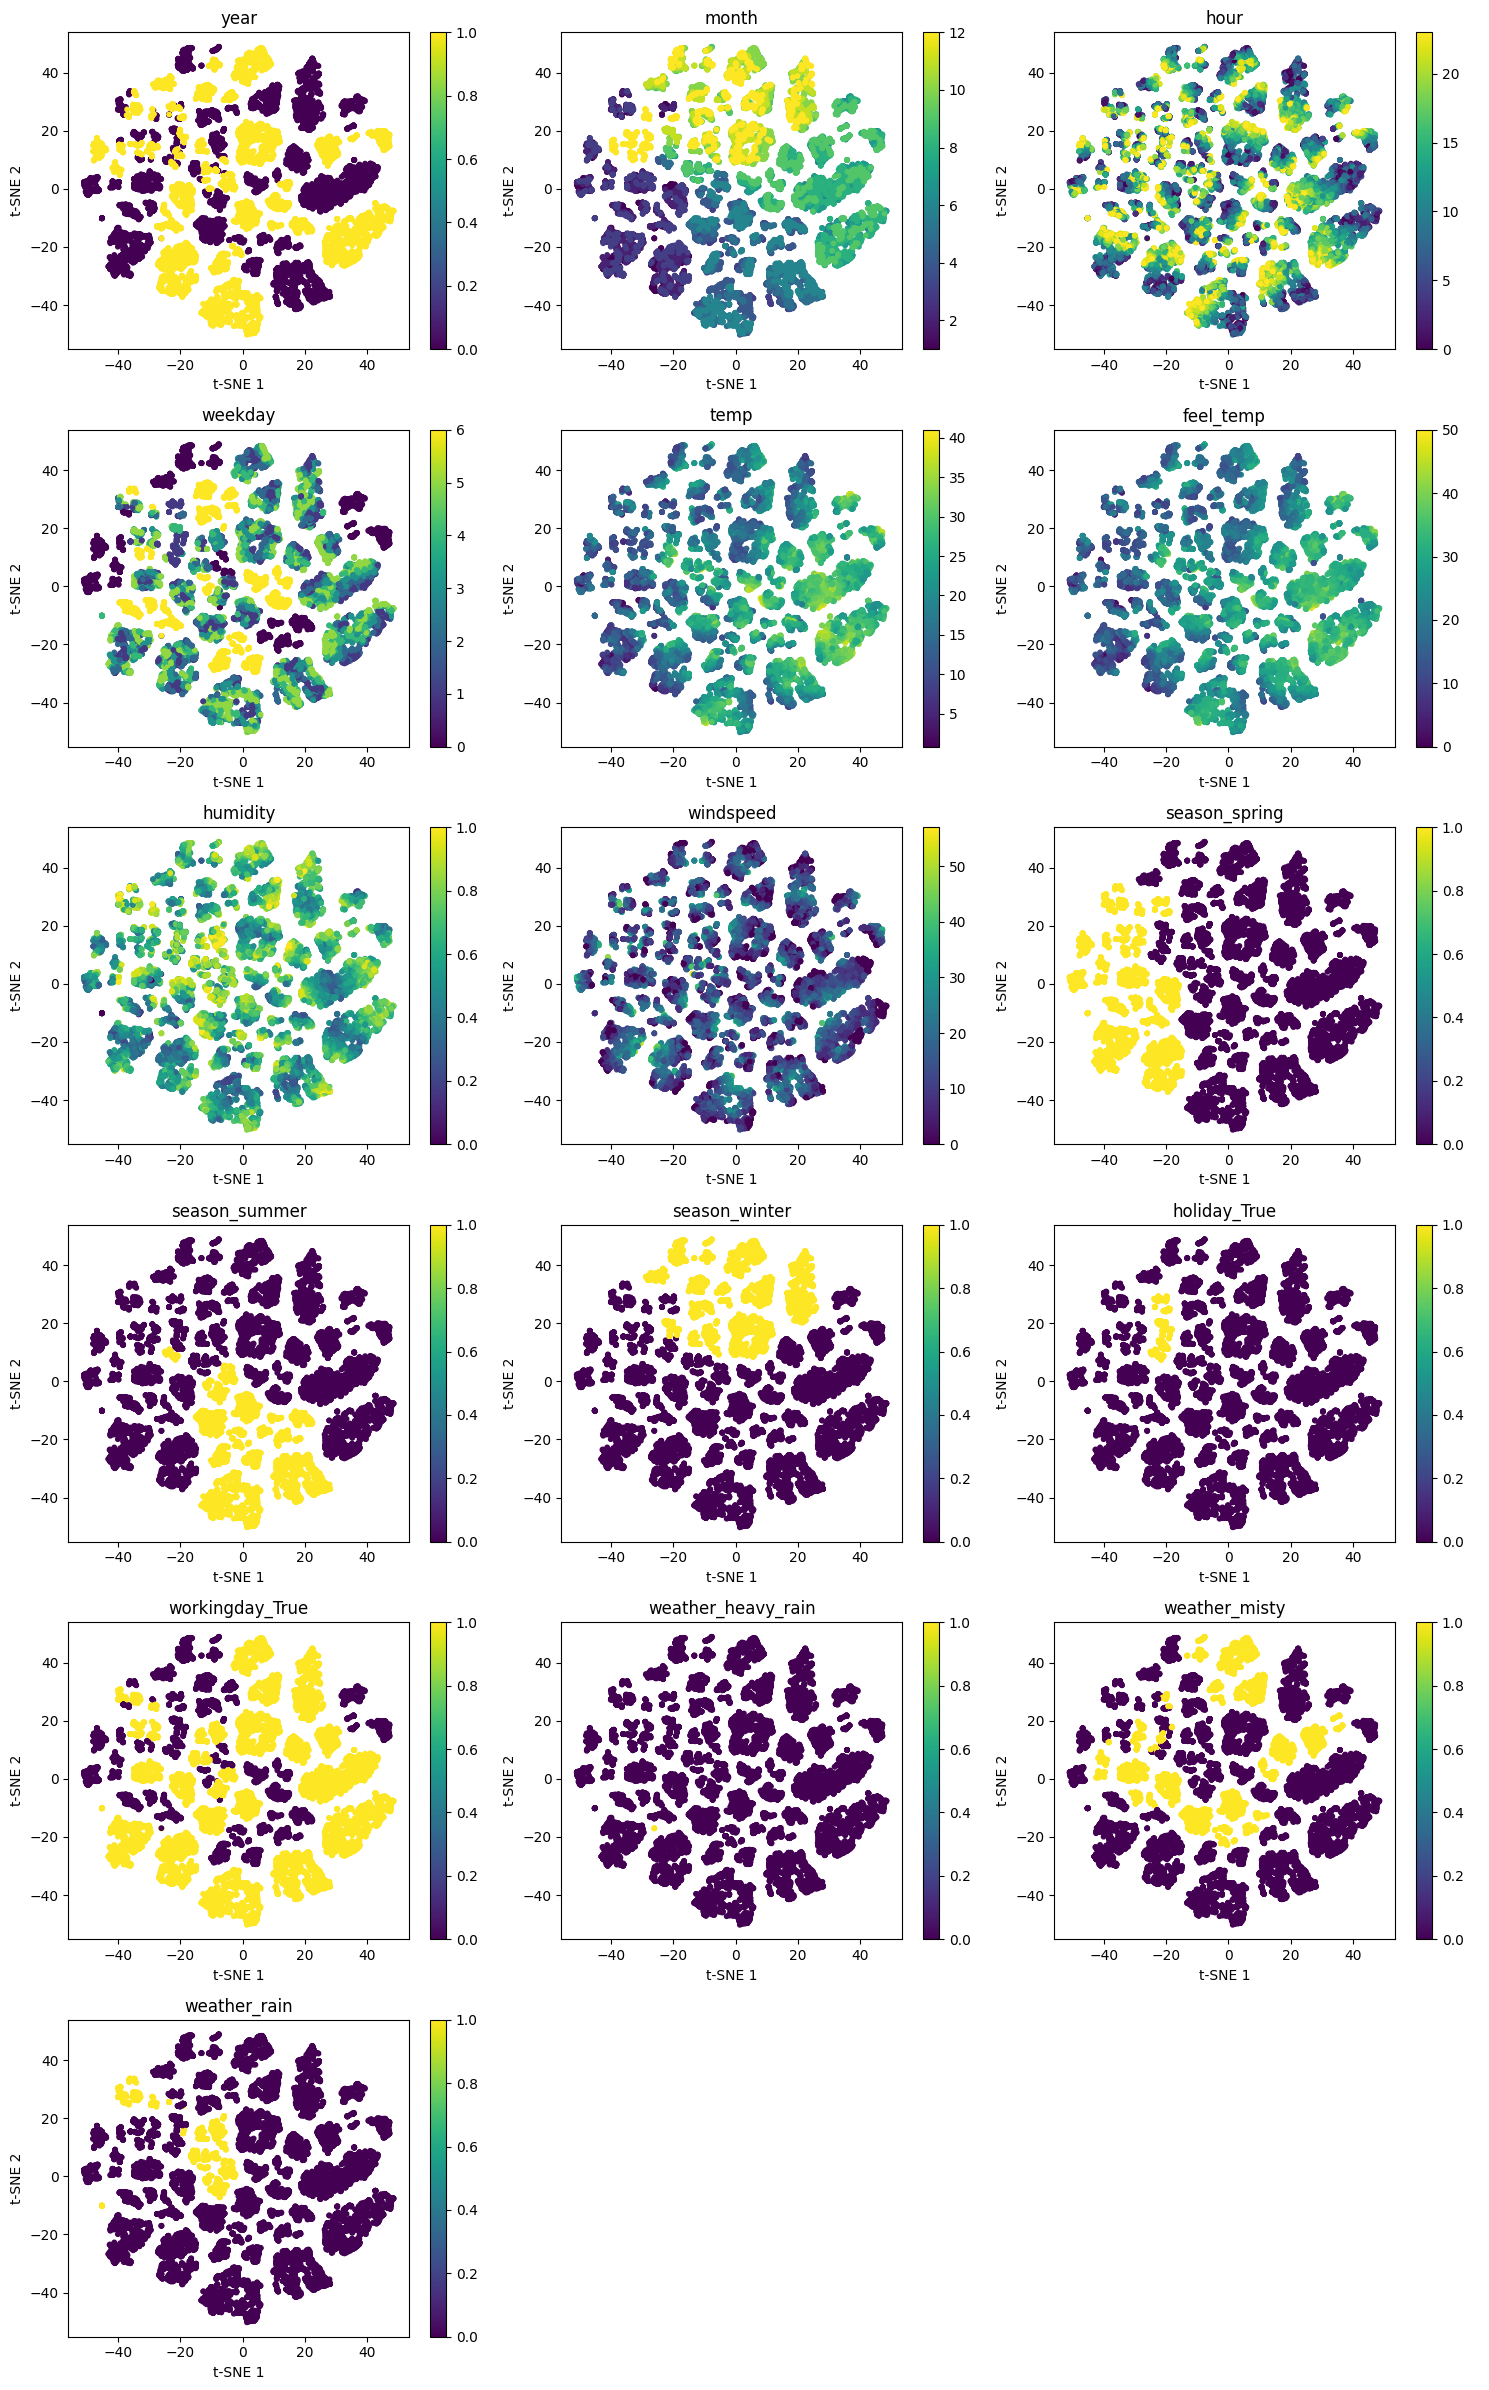

In [5]:
cols = 3
rows = math.ceil(len(bs_X_enc.columns) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

# Plot by variable
for i, feat in enumerate(bs_X_enc.columns):
    sc = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1],
                         c=bs_X_enc[feat], cmap='viridis', s=10)
    axes[i].set_title(f'{feat}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')
    plt.colorbar(sc, ax=axes[i])

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## RandomForest comparison

The Random Forest model trained on the original dataset (80% for training and 20% for testing) achieves excellent predictive accuracy, confirming that the full set of features captures most of the variability in bike rental demand. When the data are reduced to only two dimensions, model performance naturally decreases. However, the t-SNE representation outperforms PCA, as it preserves important nonlinear structures and local relationships within the data. This demonstrates that t-SNE, even in a highly compressed 2D form, retains more meaningful information for prediction than the linear PCA approach. 

In [6]:
def evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{label}")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(bs_X_scaled, bs_y, test_size=0.2, random_state=42)

# define RF model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# baseline model - full data
evaluate(rf, X_train, X_test, y_train, y_test, "Random Forest - original data")

# model on PCA (2D) data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, bs_y, test_size=0.2, random_state=42)
evaluate(rf, X_pca_train, X_pca_test, y_pca_train, y_pca_test, "Random Forest - PCA data")

# model on t-SNE (2D) data
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(X_tsne, bs_y, test_size=0.2, random_state=42)
evaluate(rf, X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test, "Random Forest - t-SNE data")


Random Forest - original data
R²: 0.944317556859418
RMSE: 1763.2074662653934

Random Forest - PCA data
R²: 0.19345386196461944
RMSE: 25539.615222720928

Random Forest - t-SNE data
R²: 0.554788173522268
RMSE: 14097.815617272583
